# Mistral AI Agents

## 1. Contexte

### 1.1 Agent de Mistral AI — une première version singulière mais efficace

Quand Mistral AI a sorti la première version de son service d'agents, l’approche détonnait. On retrouvait une interface no-code ultra-minimaliste, très proche dans l’esprit de celle des GPTs d’OpenAI : un interface utilisateur avec quelques champs à remplir (modèle, température, instructions) et un fonctionnement en few-shot prompting.

Mais là où Mistral marquait des points, c’était sur l’intégration : on pouvait utiliser l’agent directement dans “Le Chat” en le mentionnant avec @, mais aussi l'appeler par API, et donc l’intégrer très facilement dans un outil ou un flux existant. Une dualité simple mais puissante, absente des GPTs d’OpenAI à ce moment-là.

➡️ En quelques heures, j’ai mis en production un assistant RH, accessible directement dans Outlook. Le plus long ? Faire le plugin Outlook. Et depuis ? Aucun souci en production, une intégration sans accroc. C’est le cycle idée → prod le plus rapide que j’ai vécu avec un assistant IA.

[Mistral](https://www.youtube.com/watch?v=wGIPXu3IsAY) proposait un système simple, mais efficace, à l’opposé des solutions “heavyweight” du moment comme LangGraph ou l’Assistant API d’OpenAI. Une vraie réalisation à la française : quelques bonnes idées bien exécutées, quelques oublis gênants… mais un excellent rapport valeur / effort.

### 1.2 Changement du paysage agentique

Depuis, tout a changé côté agents IA. Voici les grandes tendances :
- LangChain a lancé LangGraph et sa plateforme, LangConnect, et OAP.
- OpenAI pousse Agents SDK et Responses API.
- Le protocole MCP (ModelContextProtocol.io) d'Anthropic est devenu un standard pour connecter agents et ressources.
- Les handoffs (transferts entre agents) se généralisent : OpenAI, LangGraph swarm.
👉 Dans ce contexte, quelle direction prend Mistral avec sa v2 ?

## 2. Une UI Agent débarque dans Le Chat

Une des principales nouveautés visibles est l’arrivée d’une interface de création d’agents directement intégrée à Le Chat de Mistral.

### Un éditeur d’agent simple mais efficace

L’interface est fidèle à l’approche Mistral : simple, fonctionnelle, rapide à prendre en main. Elle permet de :
- Choisir un modèle, définir un style de réponse.
- Saisir des instructions sous forme libre.
- Ajouter des outils intégrés parmi ceux disponibles : web_search, code_interpreter, image_generation, document_library, gmail, google agenda…
- Définir un champ “garde-fous” qui encadre les limites de l’agent (ex : ne pas partager de données sensibles, ne jamais nommer de personne).

### Intégration native dans la conversation

Une fois l’agent configuré, il peut être appelé directement dans une conversation avec @nomdelagent. L’expérience est très fluide. On reste dans Le Chat, sans avoir à basculer vers une autre interface, sans friction technique. 

Cette interface vise les usages immédiats et interactifs, et s’adresse à un public non technique souhaitant créer un agent rapidement sans passer par l’API.

Je n’ai pas poussé plus loin les tests fonctionnels de cette UI, car l’essentiel de mon évaluation porte sur la nouvelle API d'Agent.

## La Base des Agents 

### Objets

Il y a trois nouveaux objets principaux qui sont utilisés par l'Agents API de Mistral AI :

- **Agents** → Un ensemble de valeurs préconfigurées pour augmenter les capacités du modèle, comme des outils, des instructions et des paramètres de complétion.

- **Conversation** → Un historique des interactions et des événements passés avec un assistant, incluant les messages et les exécutions d’outils.

- **Entry** → Une action pouvant être créée par l’utilisateur ou par un assistant. Elle permet une représentation plus souple et expressive des interactions entre un utilisateur et un ou plusieurs assistants, offrant ainsi un meilleur contrôle sur la description des événements.



Commençons par quelques imports de librairies (MistralAI, pytdantic)

In [1]:
from mistralai import Mistral
from pydantic import BaseModel
import json
import os


Puis importons des fonctions utilitaires locales.

In [2]:
import importlib
import utils
importlib.reload(utils)
from utils import pretty_print_agent_response, download_and_display_agent_images

Enfin la création du client Mistral.

In [3]:
token = os.environ.get("MISTRAL_API_KEY")
client = Mistral(api_key=token)


### Création d'un Agent

Lors de la création d’un agent, plusieurs paramètres et valeurs doivent être définis à l’avance. Il s’agit de :

* **model** : Le modèle que votre agent utilisera, parmi ceux disponibles pour la complétion de chat.
* **description** : La description de l’agent, liée à la tâche qu’il doit accomplir ou au cas d’usage concerné.
* **name** : Le nom de votre agent.
* **instructions** *(optionnel)* : Les instructions principales de l’agent, également appelées *system prompt*. Elles doivent décrire précisément la tâche principale de l’agent.
* **tools** *(optionnel)* : Une liste d’outils que le modèle peut utiliser. Il existe actuellement plusieurs types d’outils :

  * **function** : Outils définis par l’utilisateur, similaires aux appels de fonction standards utilisés avec la complétion de chat.
  * **web\_search** : Outil intégré de recherche web.
  * **code\_interpreter** : Outil intégré pour l’exécution de code.
  * **image\_generation** : Outil intégré pour la génération d’images.
* **completion\_args** *(optionnel)* : Paramètres standard du *chat completion sampler*. Tous les arguments valides pour la complétion de chat sont acceptés.

---


In [4]:
# Main agent
esg_agent = client.beta.agents.create(
    model="mistral-large-latest",
    name="esg-agent",
    description="Agent used to answer ESG (Environmental, Social and Governance) related requests.",
)

Lors de la création d’un agent, vous recevrez un objet Agent contenant un identifiant d’agent. Vous pourrez ensuite utiliser cet identifiant pour engager des conversations.

In [5]:
esg_agent

Agent(model='mistral-large-latest', name='esg-agent', id='ag_068370d2cc7276fa800011513a1f31ee', version=0, created_at=datetime.datetime(2025, 5, 28, 13, 18, 36, 781323, tzinfo=TzInfo(UTC)), updated_at=datetime.datetime(2025, 5, 28, 13, 18, 36, 781325, tzinfo=TzInfo(UTC)), instructions=None, tools=[], completion_args=CompletionArgs(stop=None, presence_penalty=None, frequency_penalty=None, temperature=0.3, top_p=None, max_tokens=None, random_seed=None, prediction=None, response_format=None, tool_choice='auto'), description='Agent used to answer ESG (Environmental, Social and Governance) related requests.', handoffs=None, object='agent')

### Commencez une conversation


Une fois votre agent créé, vous pouvez engager des conversations à tout moment tout en conservant la même conversation persistante.

Vous commencez une conversation en fournissant :

* **agent\_id** : l’identifiant de l’agent, généré lors de sa création.
* **inputs** : le message de départ de la conversation. Cela peut être une simple chaîne de caractères (le premier message ou la première question de l’utilisateur), ou bien une liste de messages.

La création de la conversation retournera un **identifiant de conversation** (*conversation\_id*).

Pour poursuivre la conversation et y ajouter les échanges au fur et à mesure, vous devez fournir deux éléments :

* **conversation\_id** : l’identifiant obtenu lors du démarrage de la conversation, qui permet de retrouver l’historique stocké en interne.
* **inputs** : le message ou la réponse suivante. Il peut s’agir d’une chaîne de caractères ou d’une liste de messages.


In [6]:
response = client.beta.conversations.start(
    agent_id=esg_agent.id, inputs="Qu'est ce que l'ESG ?"
)

In [7]:
pretty_print_agent_response(response)


ID de la conversation : conv_068370d527a97f55800011c764c6bd02

Réponse finale de l'agent :
  L'ESG, ou "Environnement, Social et Gouvernance", est un cadre utilisé pour évaluer la durabilité et l'impact sociétal des entreprises. Il se compose de trois piliers principaux :

1. **Environnement (E)** : Ce pilier évalue l'impact environnemental d'une entreprise, y compris ses pratiques en matière de gestion des ressources naturelles, de réduction des émissions de carbone, de gestion des déchets, et de protection de la biodiversité. Il prend également en compte les efforts de l'entreprise pour atténuer les risques environnementaux et s'adapter aux changements climatiques.

2. **Social (S)** : Ce pilier examine les pratiques sociales de l'entreprise, telles que les conditions de travail, la diversité et l'inclusion, les relations avec les communautés locales, et le respect des droits de l'homme. Il évalue également la manière dont l'entreprise traite ses employés, ses fournisseurs et ses cl

### Continuer une conversation

Vous pouvez poursuivre la conversation ; l’historique est conservé si vous utilisez le bon identifiant de conversation."


In [8]:
response = client.beta.conversations.append(
    conversation_id=response.conversation_id, inputs="Quelle est la différence avec le CSR ?"
)

In [9]:
pretty_print_agent_response(response)


ID de la conversation : conv_068370d527a97f55800011c764c6bd02

Réponse finale de l'agent :
  L'ESG (Environnement, Social et Gouvernance) et le CSR (Corporate Social Responsibility, ou Responsabilité Sociétale des Entreprises) sont deux concepts liés à la durabilité et à l'impact sociétal des entreprises, mais ils ont des objectifs et des approches légèrement différents.

### ESG (Environnement, Social et Gouvernance)

1. **Objectif** : L'ESG est principalement utilisé par les investisseurs pour évaluer les risques et les opportunités liés à la durabilité d'une entreprise. Il sert de cadre pour analyser la performance non financière d'une entreprise et pour prendre des décisions d'investissement.

2. **Utilisateurs** : Les principaux utilisateurs de l'ESG sont les investisseurs institutionnels, les gestionnaires de fonds, et les analystes financiers.

3. **Méthodologie** : L'ESG utilise des critères standardisés et des indicateurs quantitatifs pour évaluer les performances environneme

### Mise à jour d’un agent

Après sa création, vous pouvez mettre à jour l’agent avec de nouveaux paramètres si nécessaire. Les arguments sont les mêmes que ceux utilisés lors de la création de l’agent.

In [10]:
client.beta.agents.update(
    agent_id=esg_agent.id, 
    instructions="Tu réponds de manière concise et professionnelle en 1 paragraphe.",
    completion_args={
        "temperature": 0.1,
        "top_p": 0.95,
    }
)

Agent(model='mistral-large-latest', name='esg-agent', id='ag_068370d2cc7276fa800011513a1f31ee', version=1, created_at=datetime.datetime(2025, 5, 28, 13, 18, 36, 781323, tzinfo=TzInfo(UTC)), updated_at=datetime.datetime(2025, 5, 28, 13, 22, 9, 225100, tzinfo=TzInfo(UTC)), instructions='Tu réponds de manière concise et professionnelle en 1 paragraphe.', tools=[], completion_args=CompletionArgs(stop=None, presence_penalty=None, frequency_penalty=None, temperature=0.1, top_p=0.95, max_tokens=None, random_seed=None, prediction=None, response_format=None, tool_choice='auto'), description='Agent used to answer ESG (Environmental, Social and Governance) related requests.', handoffs=None, object='agent')

In [13]:
response = client.beta.conversations.append(
    conversation_id=response.conversation_id, inputs="Et avec les SDG ?"
)

In [14]:
pretty_print_agent_response(response)


ID de la conversation : conv_068370d527a97f55800011c764c6bd02

Réponse finale de l'agent :
  L'ESG et les SDG (Sustainable Development Goals) sont deux cadres complémentaires qui visent à promouvoir la durabilité et le développement responsable, mais ils diffèrent par leur portée et leur application. L'ESG est un cadre d'évaluation utilisé principalement par les investisseurs pour mesurer la performance non financière des entreprises en matière d'environnement, de social et de gouvernance. Il se concentre sur les risques et opportunités à long terme liés à ces trois piliers. En revanche, les SDG sont un ensemble de 17 objectifs globaux adoptés par les Nations Unies pour aborder des défis mondiaux tels que la pauvreté, l'inégalité, le changement climatique et la paix. Les SDG fournissent un cadre universel pour guider les politiques et les actions à tous les niveaux, impliquant les gouvernements, les entreprises, la société civile et les individus. Les entreprises peuvent aligner leurs

### Agent Tooling

In [15]:
web_search_agent = client.beta.agents.create(
    model="mistral-large-latest",
    description="Agent that can search online for any information if needed",
    name="websearch-agent",
    tools=[{"type": "web_search"}],
)

In [16]:
response = client.beta.conversations.start(
    agent_id=web_search_agent.id, inputs="Quel est le taux directeur de la Banque centrale européenne en janvier 2025"
)
pretty_print_agent_response(response)


ID de la conversation : conv_068370e86a55793780001ee8ab0e2531

Exécution d'outil :
  Outil : web_search
  Début : 2025-05-28 13:24:25.183189+00:00
  Fin : 2025-05-28 13:24:26.377624+00:00
  ID : tool_exec_068370e892ee72b48000cd2a17f035ee

Réponse finale de l'agent :
  En janvier 2025, le taux directeur de la Banque centrale européenne (BCE) pour la facilité de dépôt a été abaissé à 2,75 % à compter du 5 février 2025. Cette décision fait suite à une série de réductions des taux directeurs par la BCE, avec des baisses consécutives entre septembre 2024 et janvier 2025
  .

  Sources citées :
    - [5e repli des taux directeurs de la BCE en janvier 2025](https://ymanci.fr/credit-immobilier/actualites/la-bce-poursuit-sur-sa-lancee-en-reduisant-ses-taux-directeurs-en-janvier-2025/) via web_search
    - [Décisions de politique monétaire](https://www.ecb.europa.eu/press/pr/date/2025/html/ecb.mp250130~530b29e622.fr.html) via web_search



In [17]:
graph_agent = client.beta.agents.create(
    model="mistral-large-latest",
    name="graph-drawing-agent",
    description="Agent used to create graphs using the code interpreter tool.",
    instructions="Use the code interpreter tool when you have to draw a graph.",
    tools=[{"type": "code_interpreter"}]
)

In [18]:
inputs = """
Dessine la matrice de double matérialité des 5 enjeux clés de mon Entreprise:
– Enjeux ESG Prioritaires = [Climat, Eau, Biodiversité, Droits humains, Inclusion]
– Pour chaque enjeux, deux scores de 1 à 5 :
 1. Importance financière (à quel point l’enjeu peut impacter les résultats) = [5, 4, 3, 2, 3]
 2. Impact d’entreprise (à quel point vous-même affectez cet enjeu) =  [4, 5, 2, 3, 4]

- Trace les enjeux sur un nuage de points avec deux axes (Importance financière sur l’axe X, Impact d’entreprise sur l’axe Y),
et ajoute les lignes médianes pour créer les 4 quadrants.
- Fais commencer et terminer les deux axes (financier et impact) à 1 et 5, pour bien cadrer les scores.
- Trace les lignes en pointillés (--) à la valeur 3 sur chaque axe pour représenter les médianes.
- Et ajoute une grille discrète en fond pour faciliter la lecture des positions
"""

response = client.beta.conversations.start(
    agent_id=graph_agent.id, inputs=inputs
)
pretty_print_agent_response(response)


ID de la conversation : conv_068370f15d4176d080009075e359493b

Exécution d'outil :
  Outil : code_interpreter
  Début : 2025-05-28 13:26:55.288032+00:00
  Fin : 2025-05-28 13:27:46.942545+00:00
  ID : tool_exec_068370f1f49b79fb80006b35c72724f2

Réponse finale de l'agent :
  Voici la matrice de double matérialité des enjeux ESG pour votre entreprise. Les enjeux sont placés sur un nuage de points avec l'importance financière sur l'axe X et l'impact d'entreprise sur l'axe Y. Les lignes médianes en pointillés et la grille discrète facilitent la lecture des positions.



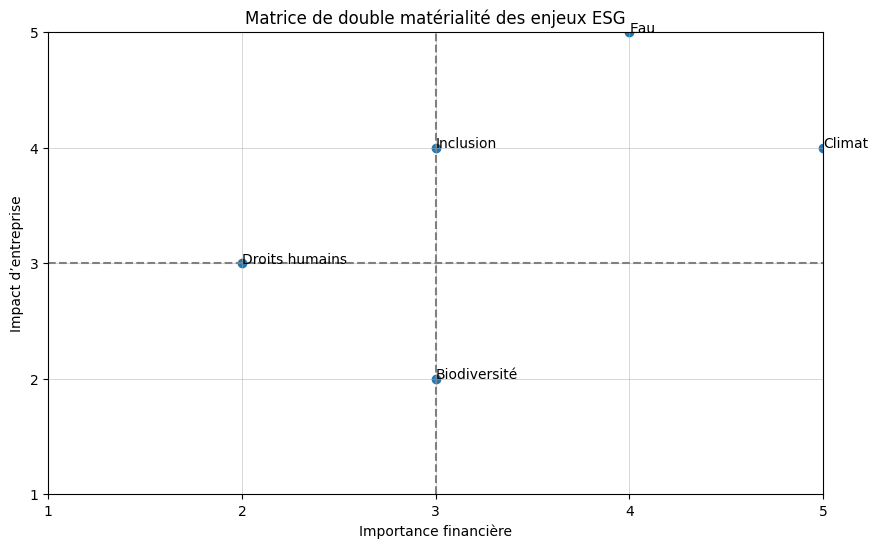

In [19]:
download_and_display_agent_images(response, client)

## Création d'un workflow agentique

Lors de la création et de l’utilisation d’agents, souvent équipés d'outils spécifiques, il arrive qu’on souhaite faire appel à d’autres agents en cours d’action. Pour concevoir et structurer des workflows automatisés couvrant une variété de tâches, cette capacité à déléguer des tâches à d’autres agents ou à leur transférer une conversation s’appelle un Handoff (transfert).

### Création des agents

In [20]:
from mistralai import CompletionArgs, ResponseFormat, JSONSchema

token = os.environ.get("MISTRAL_API_KEY")
client = Mistral(api_key=token)

class CalcResult(BaseModel):
    reasoning: str
     # JSON list of { year, value, meets_target }
    result: str

# Create your agents
calculator_agent = client.beta.agents.create(
    model="mistral-large-latest",
    name="calculator-agent",
    description="Agent used to make detailed calculations",
    instructions=r"""When doing calculations explain step by step what you are doing.
    #### Compound annual reduction rate (CARR)
    To calculate the compounded effect of reducing a quantity over time to reach a target value, you can use the formula for compound annual reduction:

    \[ r = 1 - \left( \frac{T}{B} \right)^{\frac{1}{n}} \]

    where:
    - \( r \) is the annual reduction rate (as a decimal, e.g., 0.043 for 4.3%).
    - \( B \) is the baseline value (initial quantity, e.g., emissions in year 0).
    - \( T \) is the target value (final quantity after n years).
    - \( n \) is the number of years over which the reduction occurs.""",
    completion_args=CompletionArgs(
          response_format=ResponseFormat(
            type="json_schema",
            json_schema=JSONSchema(
                name="calc_result",
                schema=CalcResult.model_json_schema(),
            )
        )
    )
)



In [21]:
# – Lookup interne esg baseline : metric + date + sector, retourne [{baseline, target, unit, yearBaseline, yearTarget, source, comment}, ...]
esg_baseline_agent = client.beta.agents.create(
    model="mistral-large-latest",
    name="esg-baseline-agent",
    description="Can find the current baseline and target of the EU taxonomy by sector and year in Europe",
    tools=[{
        "type": "function",
        "function": {
            "name": "get_esg_baseline",
            "description": "Returns the baseline of an ESG indicator (for example 'carbon_intensity' or 'water_usage') for a sector and a target year.",
            "parameters": {
                "type": "object",
                "properties": {
                    "metric": {"type": "string"},
                    "sector": {"type": "string"},
                    "date":   {"type": "string"}
                },
                "required": ["metric", "sector", "date"]
            }
        }
    }]
)

## Définir les responsabilités lors des transferts (handoff) entre agents

Une fois tous nos agents créés, nous mettons à jour les agents définis précédemment avec la liste des handoffs disponibles (transferts possibles vers d'autres agents).

In [22]:
# Allow the esg_agent to handoff the conversation to the esg_baseline_agent or web_search_agent
client.beta.agents.update(
    agent_id=esg_agent.id, 
    handoffs=[esg_baseline_agent.id, web_search_agent.id]
)


# Allow the ecb_interest_rate_agent to handoff the conversation to the graph_agent or calculator_agent
client.beta.agents.update(
    # instructions="""
    #     If the user asks for calculations, you may hand off to the calculator agent.
    #     If the user asks to plot, visualize, or graph anything hand off the task to the graph-drawing agent.
    #     You have access to both calculator-agent and graph-drawing-agent via handoffs.
    #     """,
    agent_id=esg_baseline_agent.id, 
    handoffs=[calculator_agent.id, graph_agent.id]
)


# Allow the web_search_agent to handoff the conversation to the graph_agent or calculator_agent
client.beta.agents.update(
    agent_id=web_search_agent.id, 
    # instructions="""
    #     If the user asks for calculations, you may hand off to the calculator agent.
    #     If the user asks to plot, visualize, or graph anything hand off the task to the graph-drawing agent.
    #     You have access to both calculator-agent and graph-drawing-agent via handoffs.
    #     """,
    handoffs=[calculator_agent.id, graph_agent.id]
)


Agent(model='mistral-large-latest', name='websearch-agent', id='ag_068370e7f8d67cbd8000ce20cb49eb01', version=1, created_at=datetime.datetime(2025, 5, 28, 13, 24, 15, 554940, tzinfo=TzInfo(UTC)), updated_at=datetime.datetime(2025, 5, 28, 13, 37, 58, 290808, tzinfo=TzInfo(UTC)), instructions=None, tools=[WebSearchTool(type='web_search')], completion_args=CompletionArgs(stop=None, presence_penalty=None, frequency_penalty=None, temperature=0.3, top_p=None, max_tokens=None, random_seed=None, prediction=None, response_format=None, tool_choice='auto'), description='Agent that can search online for any information if needed', handoffs=['ag_06837104175676fe8000161e87ea0096', 'ag_068370ecf9277f3d8000d75f98e3a71d'], object='agent')

### Comment ça fonctionne

Notre workflow et le comportement des agents sont désormais définis, nous pouvons donc l’exécuter.

Nous avons créé 5 agents. Certains ont accès à des outils intégrés, d'autres à des outils locaux comme `get_esg_baseline`.

Il est maintenant possible d’enchaîner plusieurs actions en envoyant une requête à `esg_agent`.

Déclenchons deux comportements différents à titre d’exemple :


#### Exemple A

**"Fetch the current US bank interest rate and calculate the compounded effect if investing for the next 10y"**

*("Récupère le taux directeur actuel de la banque centrale américaine et calcule l'effet des intérêts composés sur un investissement sur les 10 prochaines années")*

Dans ce premier exemple, on demande le taux directeur de la banque centrale des États-Unis. On s’attend donc à ce que l’agent de recherche web (websearch-agent) intervienne, suivi du calcul des intérêts composés sur 10 ans. Cette opération sera effectuée par l’agent calculateur (calculator-agent).

In [23]:
response = client.beta.conversations.start(
    agent_id=esg_agent.id,
    inputs="What are the current carbon emission levels and 2030 reduction targets for the steel industries in China?"
)   
pretty_print_agent_response(response)


ID de la conversation : conv_0683711d6b457ccd80002ab6daf8393a

Transfert d'agent (Handoff) :
  De : esg-agent
  Vers : websearch-agent
  Date : 2025-05-28 13:38:31.333678+00:00

Exécution d'outil :
  Outil : web_search
  Début : 2025-05-28 13:38:31.932746+00:00
  Fin : 2025-05-28 13:38:34.023052+00:00
  ID : tool_exec_0683711d7eec75438000a6e7c5d348b4

Exécution d'outil :
  Outil : web_search
  Début : 2025-05-28 13:38:32.682500+00:00
  Fin : 2025-05-28 13:38:34.037188+00:00
  ID : tool_exec_0683711d8aeb756b80001c39b0424aff

Réponse finale de l'agent :
  The current carbon emission levels for steel industries in China are significant. The steel industry is one of the key contributors to carbon neutrality, needing to accelerate decarbonization. Reducing energy consumption and CO2 emissions to keep up with the current global warming trend are reviewed
  .

For the 2030 reduction targets, China has set an ambitious national determined contributions target to peak CO2 emissions by 2030 and

In [24]:
response = client.beta.conversations.start(
    agent_id=esg_agent.id,
    inputs="The carbon intensity of EU steel production was 1.8 tCO₂/tonne in 2018. The target for 2030 is 1.2 tCO₂/tonne." 
    "Calculate the compound annual reduction rate over this 12-year period."
)   



In [25]:
pretty_print_agent_response(response)


ID de la conversation : conv_0683712154c17ad3800005f8dcc39548

Réponse finale de l'agent :
  To calculate the compound annual reduction rate (CARR) over the 12-year period from 2018 to 2030, we can use the formula for compound annual growth rate (CAGR), but adapted for reduction:

CARR = (End Value / Start Value)^(1/n) - 1

Where:
- End Value = 1.2 tCO₂/tonne (target for 2030)
- Start Value = 1.8 tCO₂/tonne (value for 2018)
- n = number of years (2030 - 2018 = 12 years)

Plugging in the values:

CARR = (1.2 / 1.8)^(1/12) - 1

CARR = (0.6667)^(1/12) - 1

CARR ≈ 0.9609 - 1

CARR ≈ -0.0391 or -3.91%

The compound annual reduction rate is approximately 3.91% per year.



In [32]:
from mistralai import FunctionResultEntry
import json

response = client.beta.conversations.start(
    agent_id=esg_agent.id,
    inputs="""Given the carbon intensity target in tCO2e/tonne for EU in the steel industry in 2030,
      plot a graph of the compound annual reduction rate (CARR) over the next 10 years."""
)

# Supposons que tu as déjà la variable `response` issue de la requête initiale
if response.outputs[-1].type == "function.call" and response.outputs[-1].name == "get_esg_baseline":
    # On récupère les arguments de la fonction appelée
    args = response.outputs[-1].arguments
    if isinstance(args, str):
        args = json.loads(args)  # Désérialisation si c'est une chaîne
    metric = args.get("metric", "")

    if metric == "carbon_intensity":
        result = {
            "baseline": 1.8,
            "target": 1.2,
            "unit": "tCO2e/tonne",
            "yearBaseline": 2018,
            "yearTarget": 2030,
            "source": "EUROFER",
            "comment": "Average EU steel production target"
        }
    elif metric == "water_usage":
        result = {
            "baseline": 2400,
            "target": 1900,
            "unit": "m3/hectare/year",
            "yearBaseline": 2015,
            "yearTarget": 2030,
            "source": "European Environment Agency",
            "comment": "Target for average agricultural water use per hectare in EU"
        }
    else:
        result = {"error": "Metric non supporté"}

    user_entry = FunctionResultEntry(
        tool_call_id=response.outputs[-1].tool_call_id,
        result=json.dumps(result),  # On sérialise en JSON si besoin
    )
    print("\033[1mRésultat de la fonction :\033[0m")
    print(user_entry)
    response = client.beta.conversations.append(
        conversation_id=response.conversation_id,
        inputs=[user_entry]
    )

    print(response)

Résultat de la fonction :
tool_call_id='tUHsRhfJV' result='{"baseline": 1.8, "target": 1.2, "unit": "tCO2e/tonne", "yearBaseline": 2018, "yearTarget": 2030, "source": "EUROFER", "comment": "Average EU steel production target"}' object='entry' type='function.result' created_at=None completed_at=Unset() id=None
conversation_id='conv_0683712f3c2b71c080008602d3ab7780' outputs=[AgentHandoffEntry(previous_agent_id='ag_0683710a1c317e308000458aab7bcc75', previous_agent_name='esg-baseline-agent', next_agent_id='ag_068370ecf9277f3d8000d75f98e3a71d', next_agent_name='graph-drawing-agent', object='entry', type='agent.handoff', created_at=datetime.datetime(2025, 5, 28, 13, 43, 19, 188622, tzinfo=TzInfo(UTC)), completed_at=datetime.datetime(2025, 5, 28, 13, 43, 19, 227041, tzinfo=TzInfo(UTC)), id='handoff_0683712f730476938000bc96eb3b194a'), ToolExecutionEntry(name='code_interpreter', object='entry', type='tool.execution', created_at=datetime.datetime(2025, 5, 28, 13, 43, 19, 563281, tzinfo=TzInfo(UT

In [33]:
pretty_print_agent_response(response)


ID de la conversation : conv_0683712f3c2b71c080008602d3ab7780

Transfert d'agent (Handoff) :
  De : esg-baseline-agent
  Vers : graph-drawing-agent
  Date : 2025-05-28 13:43:19.188622+00:00

Exécution d'outil :
  Outil : code_interpreter
  Début : 2025-05-28 13:43:19.563281+00:00
  Fin : 2025-05-28 13:43:28.265987+00:00
  ID : tool_exec_0683712f79027f9880006879f25b18d3

Réponse finale de l'agent :
  The graph illustrates the Compound Annual Reduction Rate (CARR) in carbon intensity for the EU steel industry over the next 10 years, from 2023 to 2033. The carbon intensity decreases from 1.8 tCO2e/tonne in 2023 to the target of 1.2 tCO2e/tonne in 2030, and continues to decrease in the following years. The CARR is calculated based on the initial and target carbon intensities, providing a clear visualization of the reduction trend over time.



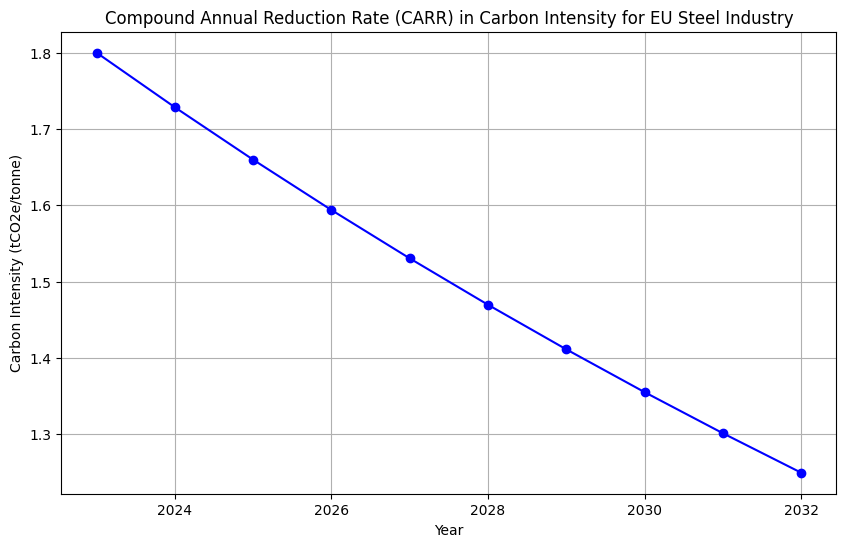

In [34]:
download_and_display_agent_images(response, client)

## 3. Le nouveau Agent API : tour d’horizon des fonctionnalités

Le cœur de ce test portait sur la nouvelle version de l’Agent API de Mistral AI, qui permet de programmer et piloter des agents exécutés directement sur la plateforme Mistral.

### 3.1 Les “classiques” désormais disponibles

- Agent API complète la Chat Completion API existante en apportant un cadre conversationnel enrichi, avec gestion de sessions persistantes côté serveur : les conversations peuvent être reprises, suivies, et enrichies dans le temps sans réinitialiser le contexte.
- Outils intégrés : web_search, code_interpreter, image_generation, document_library
- Streaming natif des réponses
- Prise en charge du function calling via un format structuré
- Support des handoffs : un agent peut déléguer à un autre, via des mécanismes similaires à ceux de LangGraph ou de l’Agents SDK
- Utilisation du protocole MCP pour accéder à des ressources ou documents connectés

### 3.2 Les originalités de Mistral

- La bonne idée de Mistral AI est de permettre de modifier les agents dynamiquement et de créer des liens entre eux a posteriori. Ces liens permettent de chaîner plusieurs agents dans un même flux, en s’appuyant sur un mécanisme de handoff automatique géré par la plateforme.
- Les agents s’exécutent directement sur la plateforme de Mistral, ce qui évite d'avoir à les exécuter sur sa propre infrastructure. Des clients sont disponibles en Python, TypeScript, ou via appel API.
	- Seuls le function_calling et MCP fonctionnent différemment : ce n’est pas la plateforme qui exécute les appels automatiquement. Il faut intercepter les événements côté client et renvoyer une réponse. Cela répond évidement à des contraintes de sécurité.

### 3.3 Les absents qu’on espère voir bientôt

- Pas d’interface de tracing pour debugger ou suivre l’exécution pas à pas.
- Les agents créés par la nouvelle API ne sont pas encore disponible dans la partie UI
- Unification incomplète entre les agents Le Chat et ceux de la plateforme.
- On regrette moins l'absence de contexte inter-agent (tout passe par la conversation), de mémoire ou d'human-in-the-loop. 

👉 Malgré ces petits manques, la nouvelle Agent API montre une volonté claire de fournir un socle solide pour des cas d’usage ciblés, avec une montée en puissance fonctionnelle tout en gardant une logique de simplicité. On sent une approche pragmatique, orientée développeurs, mais sans prétention d’unifier tous les paradigmes agentiques.

## 4. Conclusion — uniquement sur Agent API


### 4.1 Mon avis

Cette v2 de l’Agent API de Mistral coche l’essentiel pour ce qu’elle vise : offrir une solution simple, rapide à intégrer, et stable en production.

L’API s’enrichit de toutes les briques devenues standard dans l’écosystème agentique : `web_search`, `code_interpreter`, `streaming`, `handoffs`, `Document Library (beta)`, `MCP`. Mais elle conserve une sobriété rare dans un marché qui sur-construit souvent ses outils.

➡️ Ce n’est pas un framework généraliste ou un studio tout-en-un. Et justement, pour une entreprise, **c’est ce qui fait tout son intérêt**. On peut créer des assistants ciblés, intégrables rapidement dans une application métier, sans devoir déployer ni maintenir une infra complexe. Le fait que tout tourne sur la plateforme Mistral enlève aussi une grosse charge côté ops. Et surtout, ces agents sont accessibles directement via Le Chat, l’assistant conversationnel de Mistral AI, ce qui facilite leur adoption au quotidien.

Est-ce complet ? Non. Il manque encore du tracing, une gestion du contexte inter-agent, et l’unification avec UI. Mais dans une logique d’entreprise qui veut automatiser un cas d’usage bien défini, Mistral propose une réponse crédible, bien ancrée dans les besoins terrain.


### 4.2 Les plus / les moins

| ✅ Les plus                                       | ❌ Les moins                        |
| ------------------------------------------------ | ---------------------------------- |
| API + Chat dans la même logique                  | Function calling encore manuel     |
| Tools, streaming, handoffs intégrés              | Pas encore de tracing intégré      |
| Exécution sur la plateforme Mistral              | Document Library non dispo au test |
| Simplicité, efficace pour des besoins ciblés     | Deux types d’agents non unifiés    |
| Adapté à des intégrations pro sans surcoût infra | Agent Builder non mis à jour       |
